<a href="https://colab.research.google.com/github/Dkepffl/Dacon/blob/main/HD_AI_Challenge/HD_FE_1012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HD 현대 AI Chalenge**
- 구글 드라이브 어마운트를 통해 데이터 로드
- 다양한 Feature Engineering 시도용 파일
- Data Leakate 규칙
  - [Data Leakage 너무 어려워요..](https://comgenie.tistory.com/99)

## **| 구글 드라이브 어마운트**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **| 필요한 라이브러리 로드**

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import io

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import bisect
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

## **| 데이터 로드**

In [ ]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/HD현대 AI Challenge/YOUN/train_na.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/HD현대 AI Challenge/YOUN/test_na.csv', index_col=0)

In [ ]:
# 원본 데이터셋 별도 저장
train_proto = train.copy()
test_proto = test.copy()

## **| 데이터 전처리**


In [ ]:
# SAMPLE_ID 컬럼은 드랍
train.drop(columns=['SAMPLE_ID'], inplace=True)
test.drop(columns=['SAMPLE_ID'], inplace=True)

### **1. 결측치 처리**
- 베이스라인에서 test 데이터셋의 평균값으로 결측치를 채웠는데,결측치를 평균값으로 대체하여 채우는 경우, test 데이터셋 또한 train 데이터셋의 평균값을 이용하여 결측치를 처리해야 한다는 답변 발견 [평균값 Data Leakage 관련 안내](https://dacon.io/en/competitions/official/235959/talkboard/406890?page=1&dtype=recent)
- Imputation을 이용한 방법은 가능하다는 답변 확인 [test 데이터의 imputation에 관한 문의입니다.](https://dacon.io/competitions/official/235862/talkboard/405688)
- 2014~2018년의 날씨 데이터가 통으로 존재하지 않기 때문에, MICE 방법을 이용하여 대체함. [코드 참고](https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values)
- (2023.10.12) 리더 보드 점수가 매우 나빠져, 평균으로 우선 채우기로 함

In [ ]:
train.isnull().sum()

ARI_CO                 0
ARI_PO                 0
SHIP_TYPE_CATEGORY     0
DIST                   0
ID                     0
BUILT                  0
DEPTH                  0
DRAUGHT                0
SHIPMANAGER            0
FLAG                   0
U_WIND                 0
V_WIND                 0
AIR_TEMPERATURE        0
CI_HOUR                0
OIL_PCA                0
GT_PCA                 0
YEAR                   0
MONTH                  0
DAY                    0
MINUTE                 0
WEEKDAY                0
SIN_TIME               0
COS_TIME               0
LOG_BN                 0
LOG_PORT_SIZE          0
LOG_BDI_ADJ            0
LOG_GT_PCA             0
LOG_AIR_TEMPERATURE    0
LOG_OIL_PCA            0
dtype: int64

In [ ]:
train.fillna(train.mean(), inplace=True)
train.fillna(train.mean(), inplace=True)

In [ ]:
train.isnull().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ATA                   0
ID                    0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
SHIPMANAGER           0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
DUBAI                 0
BRENT                 0
WTI                   0
BDI_ADJ               0
PORT_SIZE             0
CI_HOUR               0
dtype: int64

- train 데이터셋과 test 데이터셋 모두 결측치가 채워진 것을 아래 코드를 통해 확인. 작업의 효율을 위해 코드를 돌린 셀은 삭제함
```{python}
train.isnull().sum()
test.isnull().sum()
```

In [ ]:
# 결측치 처리가 오래 걸려서 별도의 파일로 저장
train.to_csv('/content/drive/MyDrive/HD현대 AI Challenge/YOUN/train_na.csv')
test.to_csv('/content/drive/MyDrive/HD현대 AI Challenge/YOUN/test_na.csv')

### **2. 상관 관계가 높은 컬럼을 PCA를 이용해 차원 축소**
- 데이터 탐색 과정에서 컬럼들 간의 상관 관계를 확인하였다.
- 유가와 관련된 DUBAI, BRENT, WTI 컬럼들의 상관 관계가 매우 높았다.
- 선박의 용적과 관련된 GT, DEADWEIGHT, BREDATH, LENGTH 컬럼들 역시 상관관계가 높았다.
- 해당 전처리와 베이스라인 코드를 조합했을 때, MAE 값이 줄어들었다.

In [ ]:
# PCA를 이용한 차원 축소 함수
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

standard_scaler = StandardScaler()

def reduce_PCA(col_list,train, test):
  # PCA를 적용할 컬럼만 추출
  train_df = train[col_list]
  test_df = test[col_list]

  # PCA 적용을 위한 스케일링
  train_df_sclaed = standard_scaler.fit_transform(train_df)
  test_df_sclaed  = standard_scaler.transform(test_df)

  # 차원 축소
  pca_df= PCA(n_components=1)
  train_df_PCA = pca_df.fit_transform(train_df_sclaed)
  test_df_PCA = pca_df.transform(test_df_sclaed)

  return train_df_PCA, test_df_PCA

In [ ]:
# DUBAI, BRENT, WTI
# PCA 결과를 데이터프레임에 추가
train['OIL_PCA'], test['OIL_PCA'] = reduce_PCA(['DUBAI','BRENT','WTI'], train, test)

# 기존 컬럼 삭제
train.drop(['DUBAI','BRENT','WTI'], axis=1, inplace=True)
test.drop(['DUBAI','BRENT','WTI'], axis=1, inplace=True)

In [ ]:
# GT, DEADWEIGHT, BREDATH, LENGTH
# PCA 결과를 데이터프레임에 추가
train['GT_PCA'], test['GT_PCA'] = reduce_PCA(['GT', 'DEADWEIGHT', 'BREADTH', 'LENGTH'], train, test)

# 기존 컬럼 삭제
train.drop(['GT', 'DEADWEIGHT', 'BREADTH', 'LENGTH'], axis=1, inplace=True)
test.drop(['GT', 'DEADWEIGHT', 'BREADTH', 'LENGTH'], axis=1, inplace=True)

### **3. ATA 변수 처리**

In [ ]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
  df['YEAR'] = df['ATA'].dt.year
  df['MONTH'] = df['ATA'].dt.month
  df['DAY'] = df['ATA'].dt.day
  df['HOUR'] = df['ATA'].dt.hour
  df['MINUTE'] = df['ATA'].dt.minute
  df['WEEKDAY'] = df['ATA'].dt.weekday

#### **항구별 평균 대기 시간 시계열 그래프**
- 항구별로 모델을 다르게 할 지 확인

In [ ]:
port = train['ARI_PO'].unique().tolist()

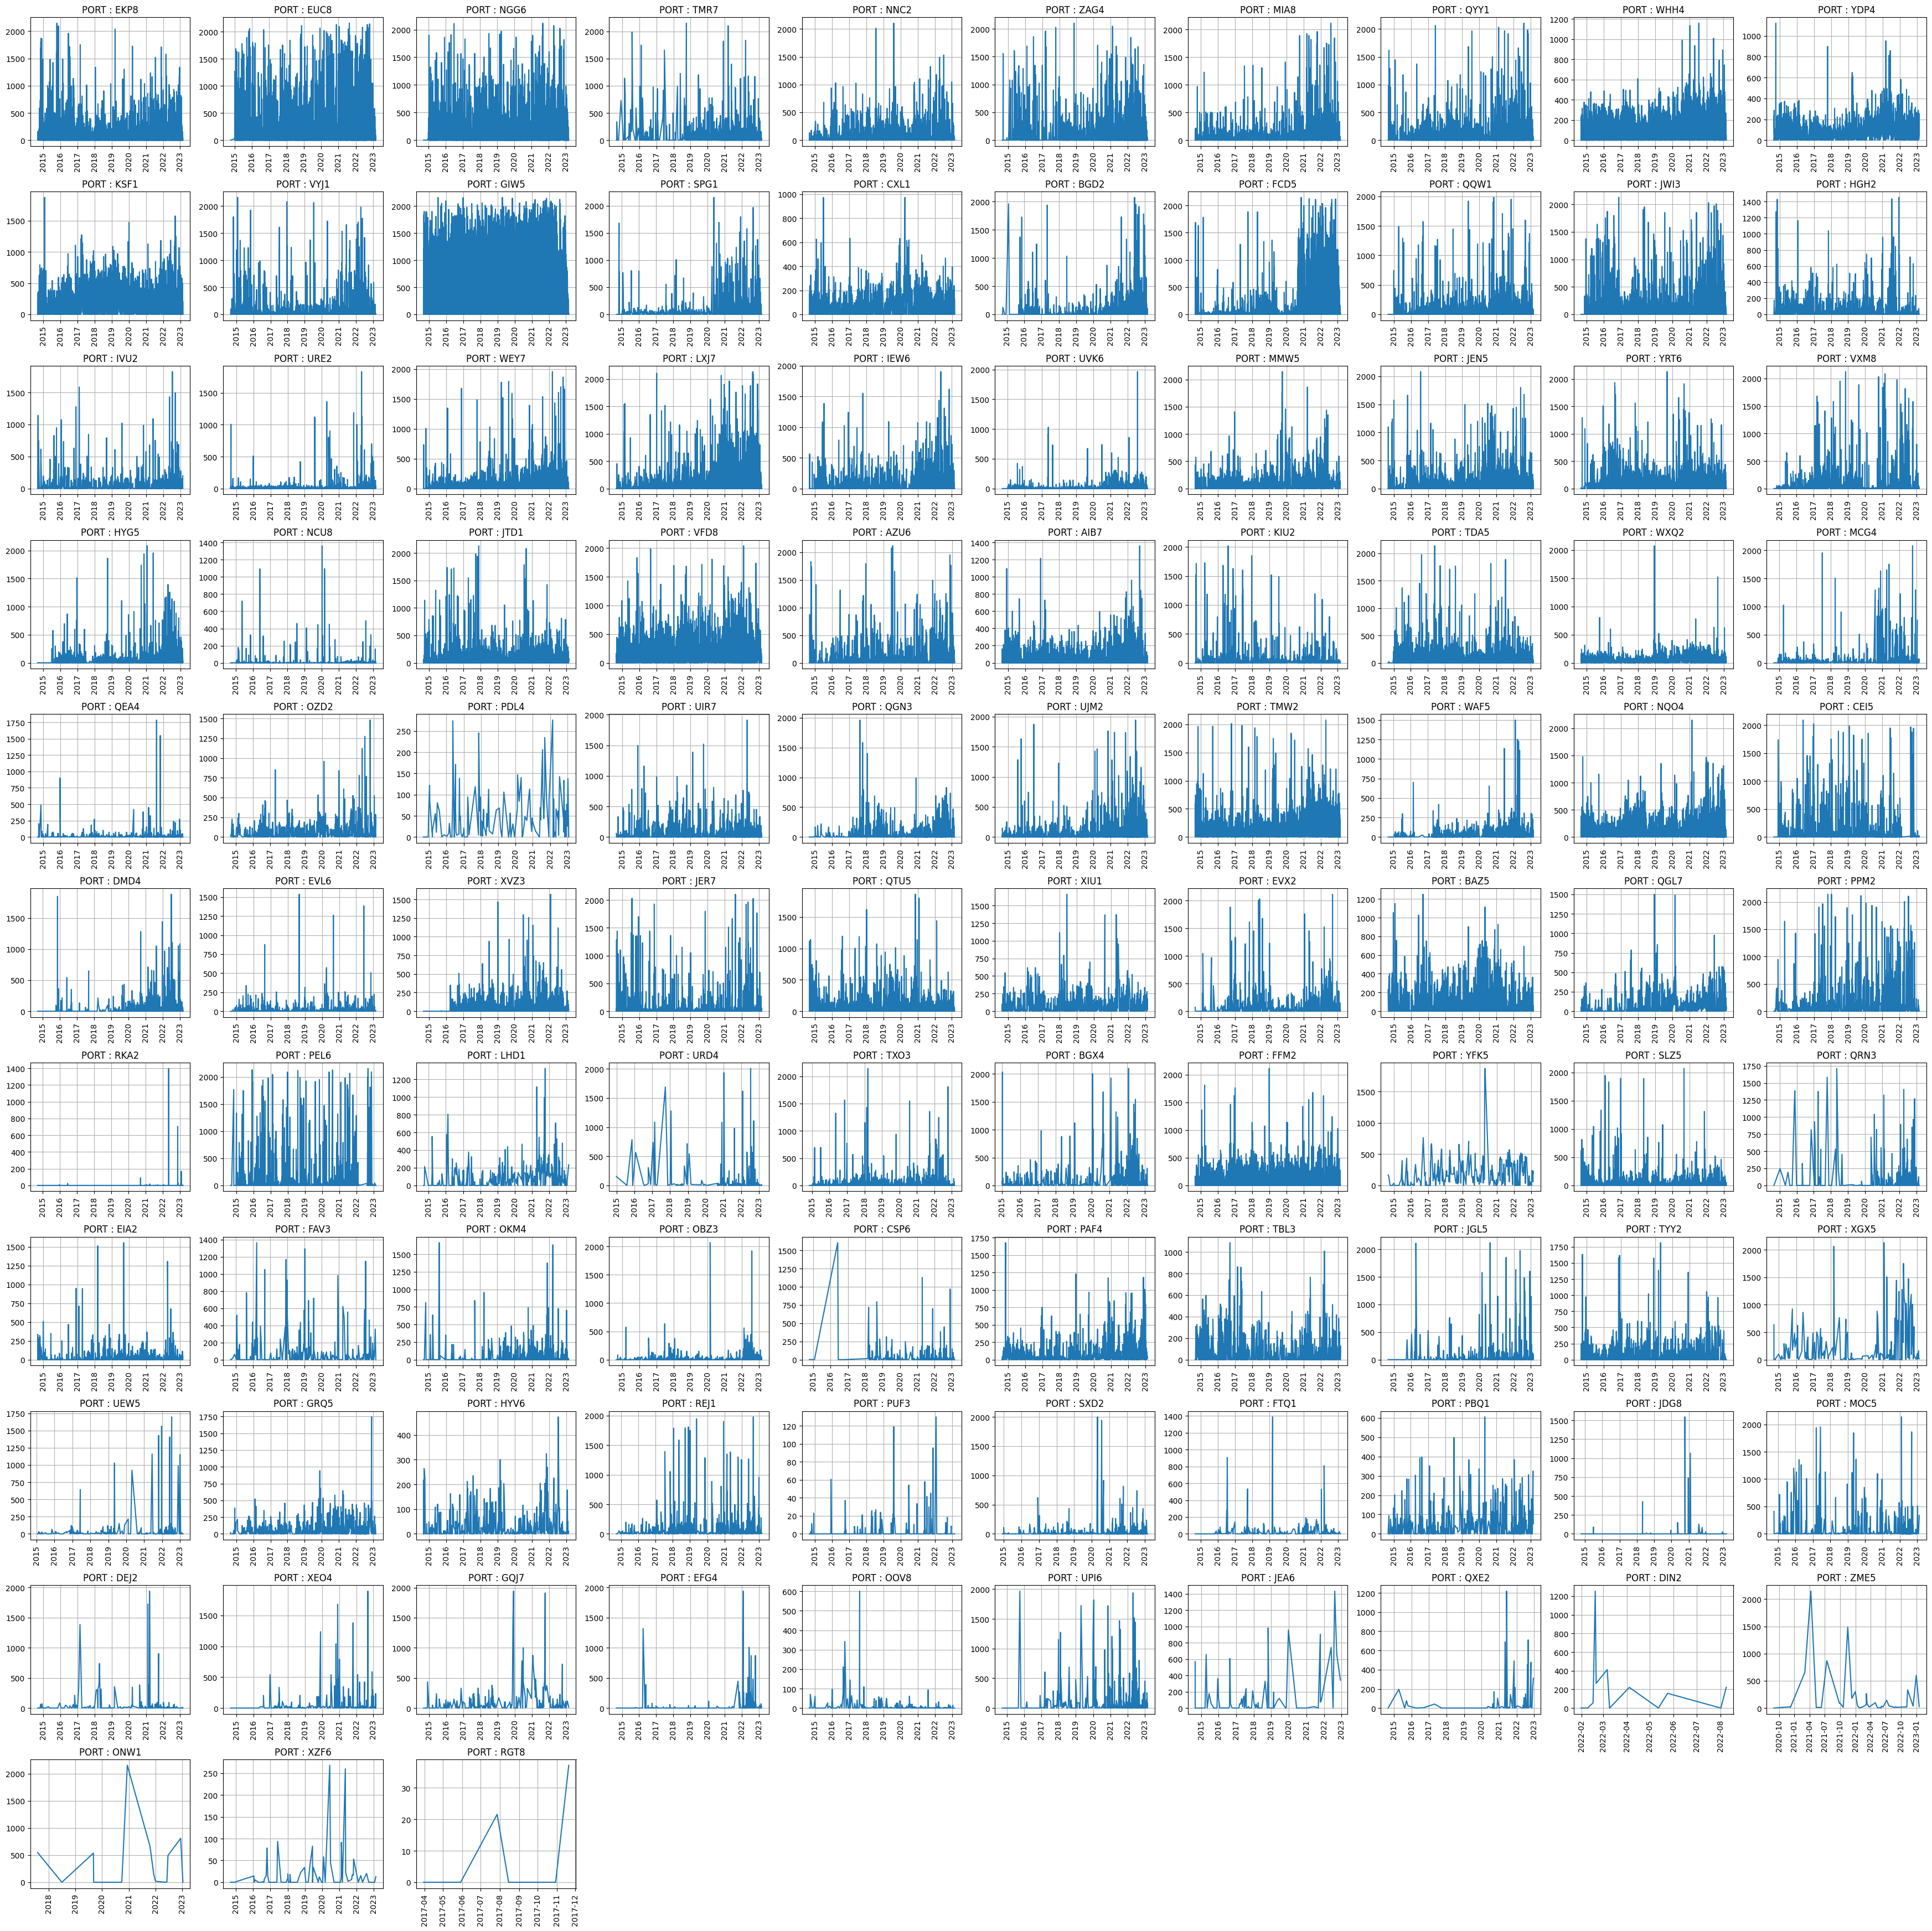

In [ ]:
from matplotlib import dates

fig = plt.figure(figsize=(35,35)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
i=1

for col in port:
  df = train[train.ARI_PO == col]
  df = df[["ATA", "CI_HOUR"]]

  df.index = df['ATA']
  df.set_index('ATA', inplace=True)

  ax = fig.add_subplot(11,10,i)

  i+=1

  plt.plot(df.groupby('ATA')['CI_HOUR'].agg('mean'))
  plt.title("PORT : {}".format(col))
  plt.grid()
  plt.xticks(rotation=90)

fig.tight_layout()
plt.show()

#### **ATA_LT 컬럼 제거**
HOUR의 상관 계수가 더 높아서 `ATA_LT` 드랍

In [ ]:
corrmat = train[['HOUR','ATA_LT', 'CI_HOUR']].corr()
corrmat

,HOUR,ATA_LT,CI_HOUR
HOUR,1.000000,-0.201999,0.008436
ATA_LT,-0.201999,1.000000,-0.000283
CI_HOUR,0.008436,-0.000283,1.000000


In [ ]:
# ATA_LT 드랍
train.drop(columns='ATA_LT', inplace=True)
test.drop(columns='ATA_LT', inplace=True)

In [ ]:
# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

#### **요일별 평균 대기 시간**

<Axes: xlabel='WEEKDAY', ylabel='CI_HOUR'>

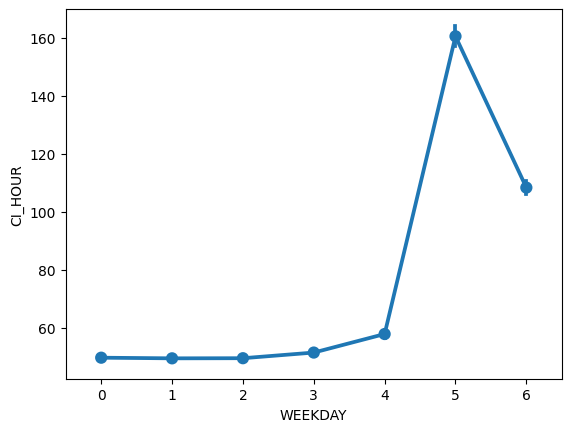

In [ ]:
sns.pointplot(x='WEEKDAY', y='CI_HOUR', data=train)

In [ ]:
train.groupby('WEEKDAY')['CI_HOUR'].agg(['mean', 'std', 'min', 'max'])

,mean,std,min,max
WEEKDAY,,,,
0,49.778559,149.771102,0.000000,2116.804167
1,49.559003,153.232838,0.000000,2144.204444
2,49.600229,156.367137,0.000000,2157.861389
3,51.550094,163.792961,0.000000,2158.901944
4,57.942400,172.839057,0.000000,2159.130556
5,160.613229,236.907537,24.155000,2158.467500
6,108.431489,207.415035,0.167778,2136.011111


- 평일과 주말로 나눠봐도 좋을 것 같다.

#### **Cyclical Time Encoding**

In [ ]:
train['SIN_TIME'] = np.sin(2*np.pi*train.HOUR/24)
train['COS_TIME'] = np.cos(2*np.pi*train.HOUR/24)

In [ ]:
test['SIN_TIME'] = np.sin(2*np.pi*test.HOUR/24)
test['COS_TIME'] = np.cos(2*np.pi*test.HOUR/24)

In [ ]:
train.drop(['HOUR'], axis = 1, inplace = True)
test.drop(['HOUR'], axis = 1, inplace = True)

### **4. 로그 변환 및 스케일링**

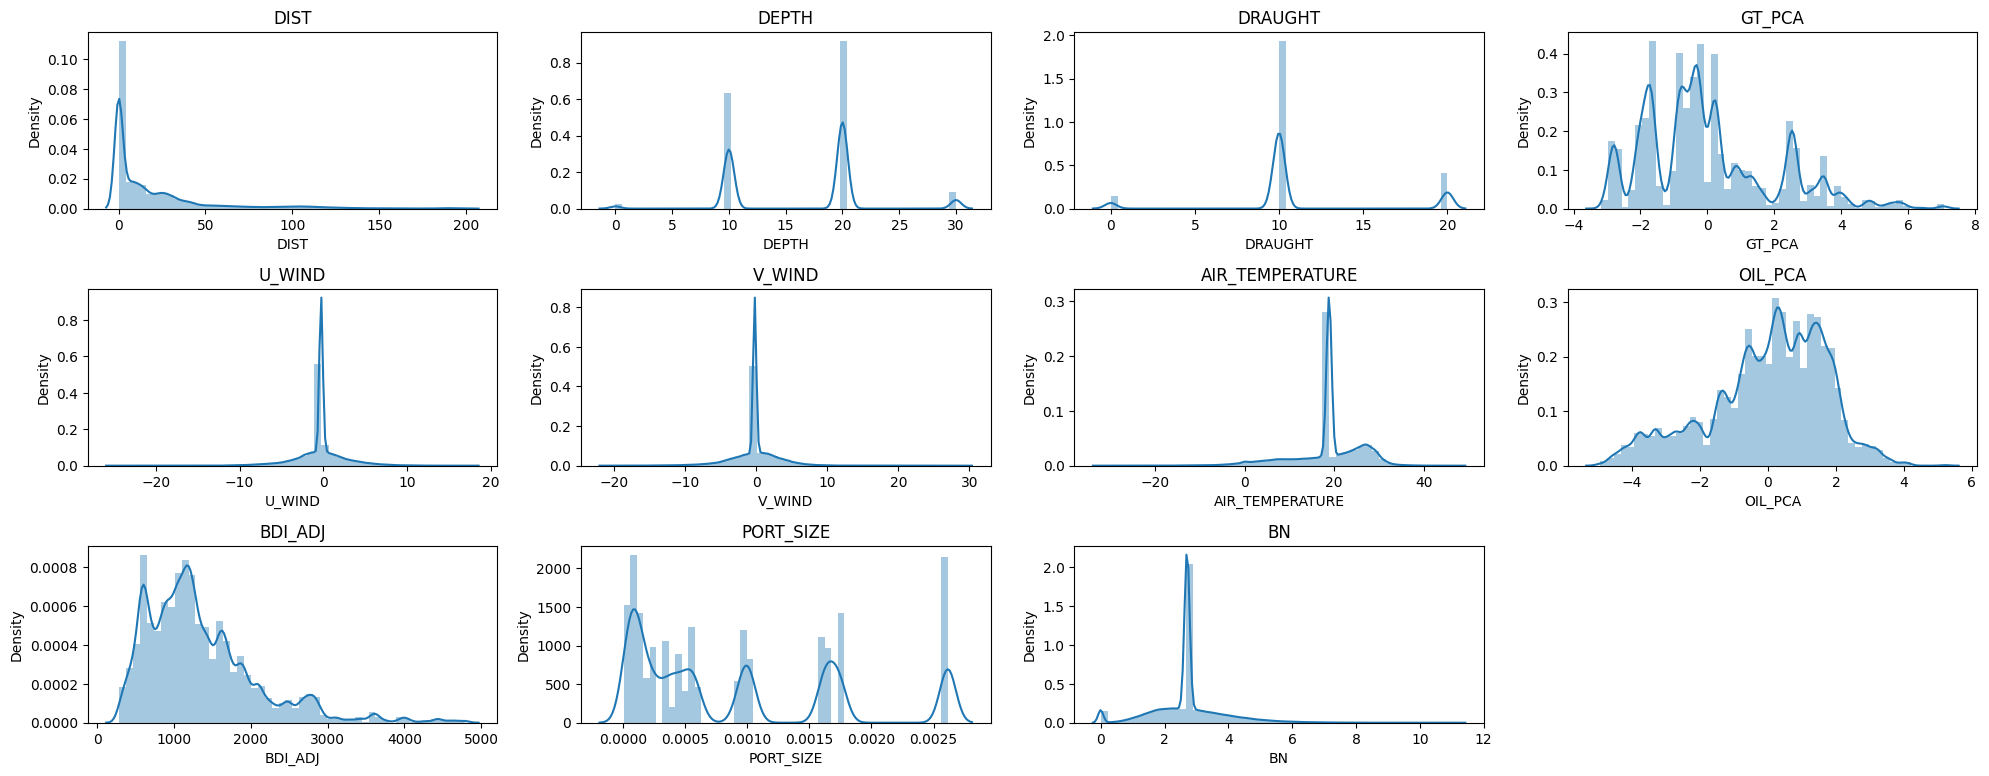

In [ ]:
# 수치형 변수 분포 확인
dist_list = ['DIST', 'DEPTH','DRAUGHT','GT_PCA','U_WIND','V_WIND','AIR_TEMPERATURE','OIL_PCA','BDI_ADJ','PORT_SIZE', 'BN']
i=0

plt.figure(figsize=(20,10))

for col in dist_list:
  plt.subplot(4,4,i+1)
  sns.distplot(train[col])
  plt.title(col)
  i+=1

plt.tight_layout()
plt.show()

In [ ]:
positive_list = ['BN', 'PORT_SIZE', 'BDI_ADJ']
negative_list = ['GT_PCA', 'AIR_TEMPERATURE', 'OIL_PCA']

for col in positive_list:
  train["LOG_"+col] = np.log1p(train[col])
  test["LOG_"+col] = np.log1p(test[col])

  train.drop(columns=col, inplace=True)
  test.drop(columns=col, inplace=True)

for col in negative_list:
  train["LOG_"+col] = np.log1p(abs(train[col]))
  train.loc[train[col]<0, "LOG_"+col] = -train[col]

  test["LOG_"+col] = np.log1p(abs(test[col]))
  test.loc[train[col]<0, "LOG_"+col] = -test[col]

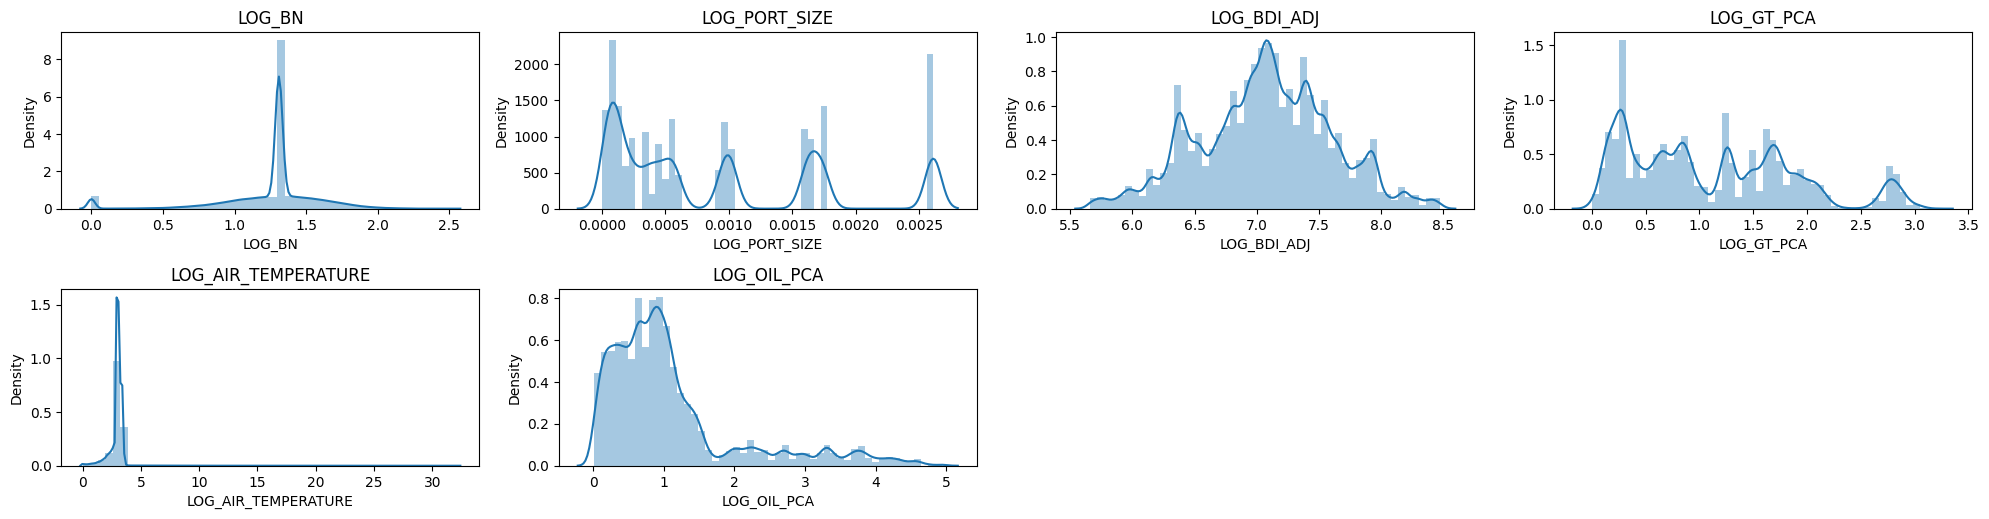

In [ ]:
# 수치형 변수 분포 확인
dist_list = ['LOG_BN', 'LOG_PORT_SIZE', 'LOG_BDI_ADJ','LOG_GT_PCA', 'LOG_AIR_TEMPERATURE', 'LOG_OIL_PCA']
i=0

plt.figure(figsize=(20,10))

for col in dist_list:
  plt.subplot(4,4,i+1)
  sns.distplot(train[col])
  plt.title(col)
  i+=1

plt.tight_layout()
plt.show()

In [ ]:
scale_list = ['DIST','U_WIND', 'V_WIND', 'LOG_BN', 'LOG_PORT_SIZE', 'LOG_GT_PCA', 'LOG_AIR_TEMPERATURE', 'LOG_OIL_PCA']

scaler = StandardScaler()
train[scale_list] = standard_scaler.fit_transform(train[scale_list])
test[scale_list] = standard_scaler.transform(test[scale_list])

### **5. 카테고리 변수 인코딩**

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['ARI_CO', 'ARI_PO', 'SHIPMANAGER', 'FLAG', 'ID', 'SHIP_TYPE_CATEGORY']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
  le = LabelEncoder()
  train[feature] = le.fit_transform(train[feature].astype(str))
  le_classes_set = set(le.classes_)
  test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
  le_classes = le.classes_.tolist()
  bisect.insort_left(le_classes, '-1')
  le.classes_ = np.array(le_classes)
  test[feature] = le.transform(test[feature].astype(str))
  encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


## **| 데이터 저장**

In [ ]:
train.to_csv('/content/drive/MyDrive/HD현대 AI Challenge/YOUN/train_1012.csv')
test.to_csv('/content/drive/MyDrive/HD현대 AI Challenge/YOUN/test_1012.csv')

## **| 모델 학습 및 특성 중요도 확인**

In [ ]:
X = train.drop(['CI_HOUR'], axis=1)
Y = train["CI_HOUR"]

# 학습/검증 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.4, random_state=0)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

model = XGBRegressor()

params = {
   'n_estimators' : [100, 200, 300, 400],
   'max_depth' : [3, 4, 5, 6],
   'learning_rate' : [0.05, 0.1]
}

xgb_grid = GridSearchCV(model, param_grid = params, cv=5, verbose=0)
xgb_grid.fit(X_train,  y_train, early_stopping_rounds=30, eval_metric='mae', eval_set=[(X_valid, y_valid)])

In [ ]:
print(xgb_grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400}


Model Tune for XGB.


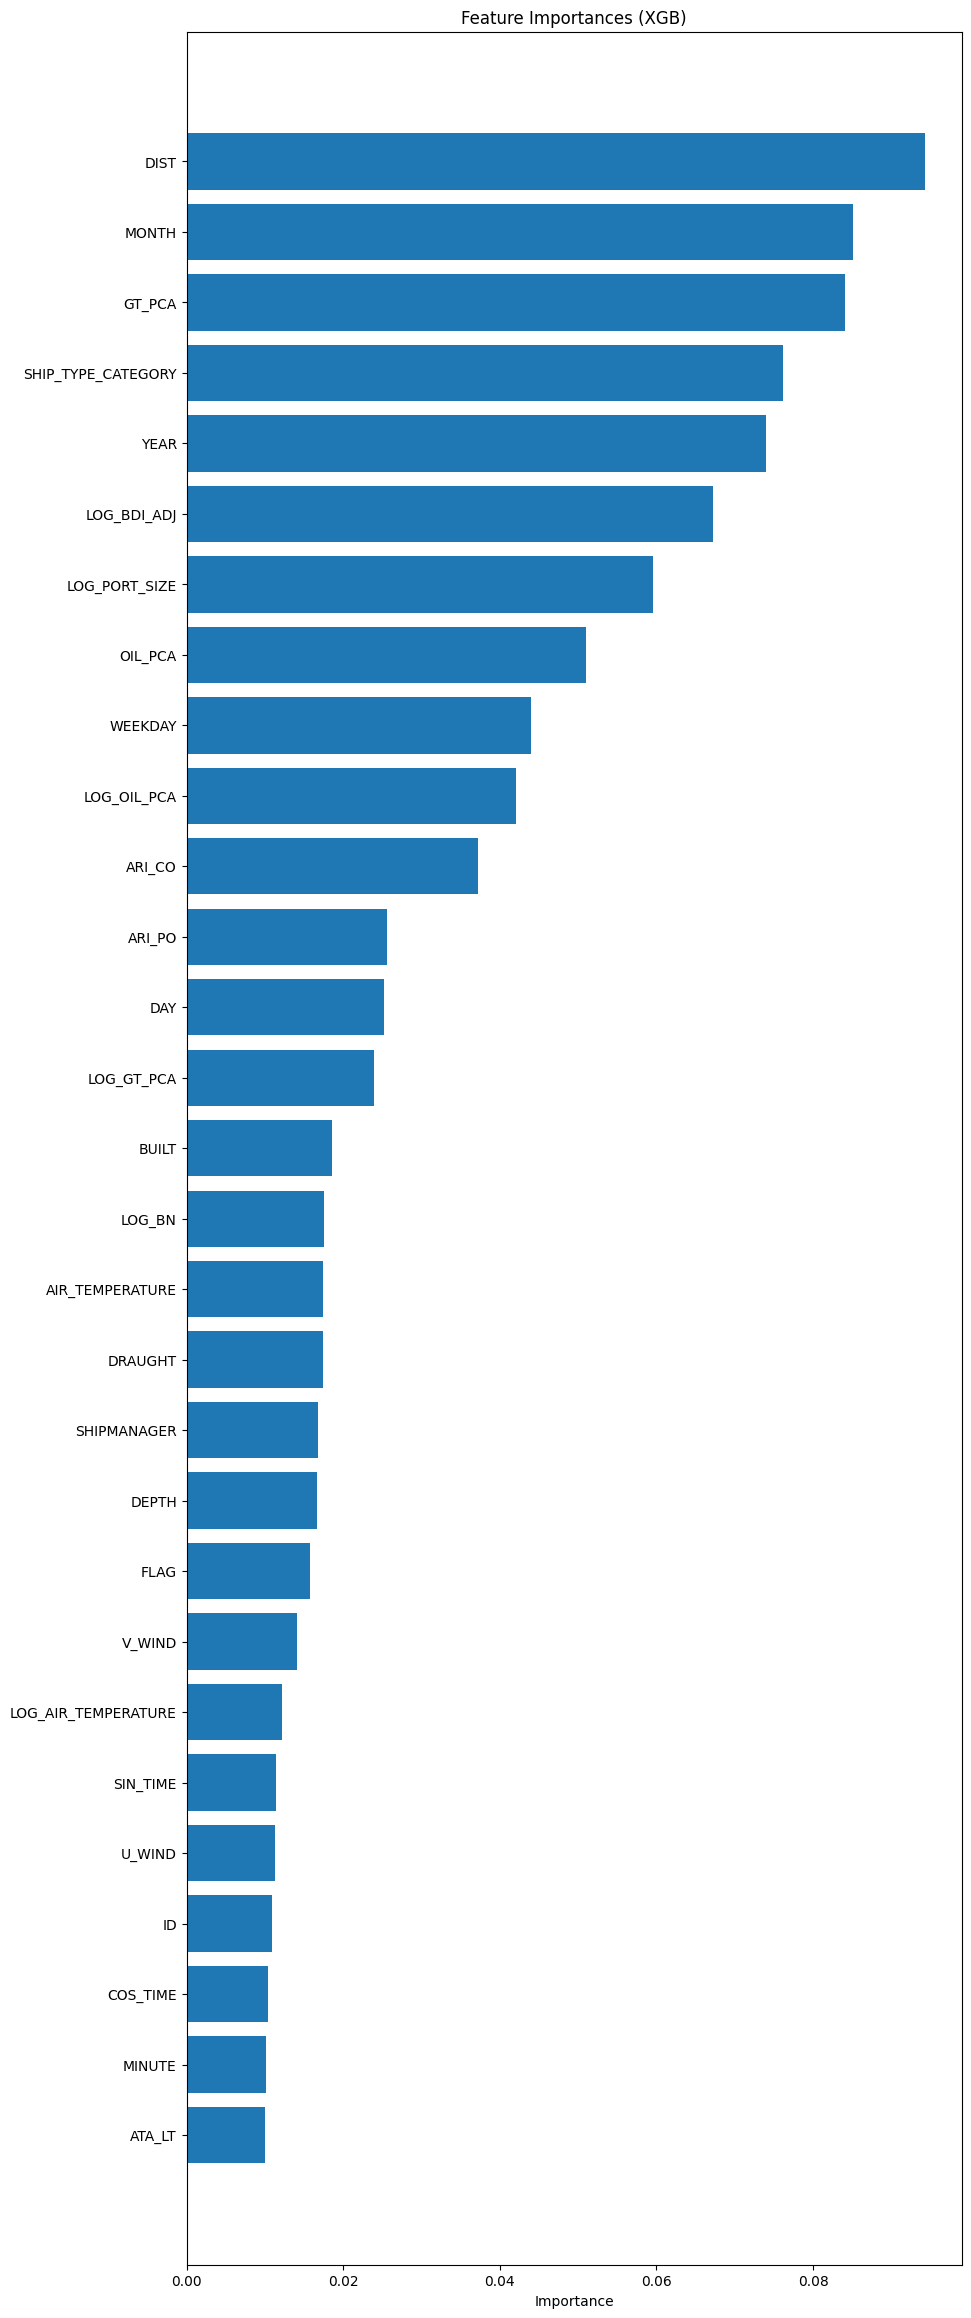

In [ ]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

# Model Tune
model, feature_importances = train_and_evaluate(XGBRegressor(learning_rate=0.1, max_depth=6, n_estimators=400), 'XGB', X, Y)

In [ ]:
threshold = 0.04 # Your Threshold
low_importance_features = X.columns[feature_importances < threshold]

X_train_reduced = X.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(learning_rate=0.1, max_depth=6, n_estimators=400)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = Y[train_idx], Y[val_idx]

    # 두 모델 모두 학습
    xgb.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgb.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = xgb.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold 별 모델들의 앙상블 예측 생성
final = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds: 100%|██████████| 5/5 [00:39<00:00,  7.84s/it]

Validation : MAE scores for each fold: [44.58913592539688, 44.34002143371116, 44.69274329070394, 44.831055132299404, 45.26366122174647]
Validation : MAE: 44.74332340077157


## **| 제출 파일 생성**

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/HD현대 AI Challenge/Data/sample_submission.csv')
submit['CI_HOUR'] = final
submit.to_csv('/content/drive/MyDrive/HD현대 AI Challenge/YOUN/submit1012_2.csv', index=False)